In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

import glob, os

In [2]:
def app2act_transform(lat,lon,h,theta,phi):
    """
    Input:
        lat,lon are in degrees
        h: hight of clouds in [km]
        theta and phi are in degrees
        
    """
    
    R = 6.371e6 # the radius of earth unit in meters
    a = h*1000/(np.tan((theta)*np.pi/180-np.pi/4))
    
    dx = np.sin((phi-13)*np.pi/180)*a
    dy = -np.cos((phi-13)*np.pi/180)*a
    
    lat1 = lat + 180*dx/(np.pi*R*np.cos(lon*np.pi/180))
    lon1 = lon + 180*dy/(np.pi*R)
    # lat1 = lat+dx
    # lon1 = lon+dy
    
    return lat1,lon1

def extract_tensor(sample_ds):
    # extract date to numpy arrays
    heights = sample_ds.cloud_edge_height.values 
    lats = sample_ds.latitude.values
    lons = sample_ds.longitude.values
    theta = sample_ds.theta_view.values
    phi = sample_ds.phi_view.values

    print(heights.shape)
    print(lats.shape)
    print(lons.shape)
    print(theta.shape)
    print(phi.shape)

    # from bottom to top lat, lons, heights, theta, phi
    input_tensor = np.stack([lats,lons,heights,theta,phi], axis=0)
    print('shape of input tensor: ',input_tensor.shape)
    return input_tensor

def imageTransform(image_tensor):
    """
    Input: (5,600,1000)
    Output: (2, 600,1000) bottom lat top lon
    """
    k,m,n = image_tensor.shape
    projected_image = np.zeros((2,m,n))

    lat1,lon1 = app2act_transform(image_tensor[0,:,:],image_tensor[1,:,:],image_tensor[2,:,:],image_tensor[3,:,:],image_tensor[4,:,:])#lat,lon,h,theta,phi)
    projected_image[0,:,:]=lat1
    projected_image[1,:,:]=lon1
    print(projected_image.shape)

    return projected_image

def findaAllFiles(folder="/Data",extn ="/*.nc"):
    """
    Note: find the data file inside a given folder
    """
    
    mydir = os.getcwd()
    mydir += folder
    try:
        os.mkdir(mydir)
        print('New folder added:',mydir)
    except(FileExistsError):
        pass
   
    files = []
    for file in glob.glob(mydir+extn):
        files.append(file)
    
    return files


def scatterPlot(output_tensor,input_tensor,filename):
    namelists = filename.split('/')
    print(namelists)
    lons = output_tensor[1,:,:].flatten()         # 1D numpy
    lats = output_tensor[0,:,:].flatten()          # 1D numpy
    cths = input_tensor[2,:,:].flatten() # 1D numpy

    ## Then, you can e.g. simply do (nb: points plotted individually):
    plt.figure(figsize=(15,10))
    plt.scatter(lons, lats, c=cths, cmap='magma', s=0.1)
    plt.title(namelists[-1])

    
def update_xarray(sample_ds,output_tensor,filename,folder="/Data"):
    
    sample_ds["true_latitude"] = 0*sample_ds.latitude.copy(deep=True)
    sample_ds["true_latitude"] += output_tensor[0,:,:]

    sample_ds["true_longitude"] = 0*sample_ds.longitude.copy(deep=True)
    sample_ds["true_longitude"] += output_tensor[1,:,:]


    comp = {"zlib": True, "complevel": 9} # < very small file (just takes a bit of time to write)
    encoding = {var: comp for var in sample_ds.data_vars}

    # write to file
    mypath = os.getcwd()
    mypath += folder
    file = filename.split('/')[-1]
    try:
        os.mkdir(mypath)
        print('New folder added:',mypath)
    except(FileExistsError):
        pass
    sample_ds.to_netcdf(mypath+f"/new_{file}", encoding=encoding)
    print(f'{file} is updated to {mypath}/new_{file}!')
    

In [3]:
# filenames
findaAllFiles(folder="/InitialData",extn ="/*.nc") # 0 to 9 are the following filenames

['/home/yz3259/Documents/Python_Jupyter_projects/SWI2023/swi-challenge-2023-netcdf-tutorial-master/InitialData/12_03_10_B2.nc',
 '/home/yz3259/Documents/Python_Jupyter_projects/SWI2023/swi-challenge-2023-netcdf-tutorial-master/InitialData/12_04_10_B3.nc',
 '/home/yz3259/Documents/Python_Jupyter_projects/SWI2023/swi-challenge-2023-netcdf-tutorial-master/InitialData/12_03_10_A2.nc',
 '/home/yz3259/Documents/Python_Jupyter_projects/SWI2023/swi-challenge-2023-netcdf-tutorial-master/InitialData/12_04_10_A1.nc',
 '/home/yz3259/Documents/Python_Jupyter_projects/SWI2023/swi-challenge-2023-netcdf-tutorial-master/InitialData/12_05_10_B4.nc',
 '/home/yz3259/Documents/Python_Jupyter_projects/SWI2023/swi-challenge-2023-netcdf-tutorial-master/InitialData/12_02_10_B1.nc',
 '/home/yz3259/Documents/Python_Jupyter_projects/SWI2023/swi-challenge-2023-netcdf-tutorial-master/InitialData/12_01_10_A4.nc',
 '/home/yz3259/Documents/Python_Jupyter_projects/SWI2023/swi-challenge-2023-netcdf-tutorial-master/Initi

Give a digit between 0 and 9 to load a file. 9


/home/yz3259/Documents/Python_Jupyter_projects/SWI2023/swi-challenge-2023-netcdf-tutorial-master/InitialData/12_02_10_A3.nc


<xarray.Dataset>
Dimensions:            (iy: 630, ix: 1000)
Coordinates:
  * ix                 (ix) int64 999 998 997 996 995 994 993 ... 6 5 4 3 2 1 0
  * iy                 (iy) int64 0 1 2 3 4 5 6 ... 623 624 625 626 627 628 629
Data variables:
    cloud_edge_height  (iy, ix) float32 0.0675 0.0675 0.0675 ... nan nan nan
    latitude           (iy, ix) float64 13.57 13.57 13.57 ... 14.14 14.14 14.14
    longitude          (iy, ix) float64 301.3 301.3 301.3 ... 300.4 300.4 300.4
    theta_view         (iy, ix) float32 140.9 140.9 140.9 140.9 ... nan nan nan
    phi_view           (iy, ix) float32 92.21 92.21 92.19 92.19 ... nan nan nan
    y_DALES            (iy) float32 0.0 0.1 0.2 0.3 0.4 ... 62.6 62.7 62.8 62.9
    x_DALES            (ix) float32 99.95 99.85 99.75 99.65 ... 0.25 0.15 0.05
Attributes:
    scene:     DALES_highres PAN
    timeslot:  12_02_10
    view:      A3

(630, 1000)
(630, 1000)
(630, 1000)
(630, 1000)
(630, 1000)
shape of input tensor:  (5, 630, 1000)
(2, 630, 1000)
['', 'home', 'yz3259', 'Documents', 'Python_Jupyter_projects', 'SWI2023', 'swi-challenge-2023-netcdf-tutorial-master', 'InitialData', '12_02_10_A3.nc']
12_02_10_A3.nc is updated to /home/yz3259/Documents/Python_Jupyter_projects/SWI2023/swi-challenge-2023-netcdf-tutorial-master/Data/new_12_02_10_A3.nc!


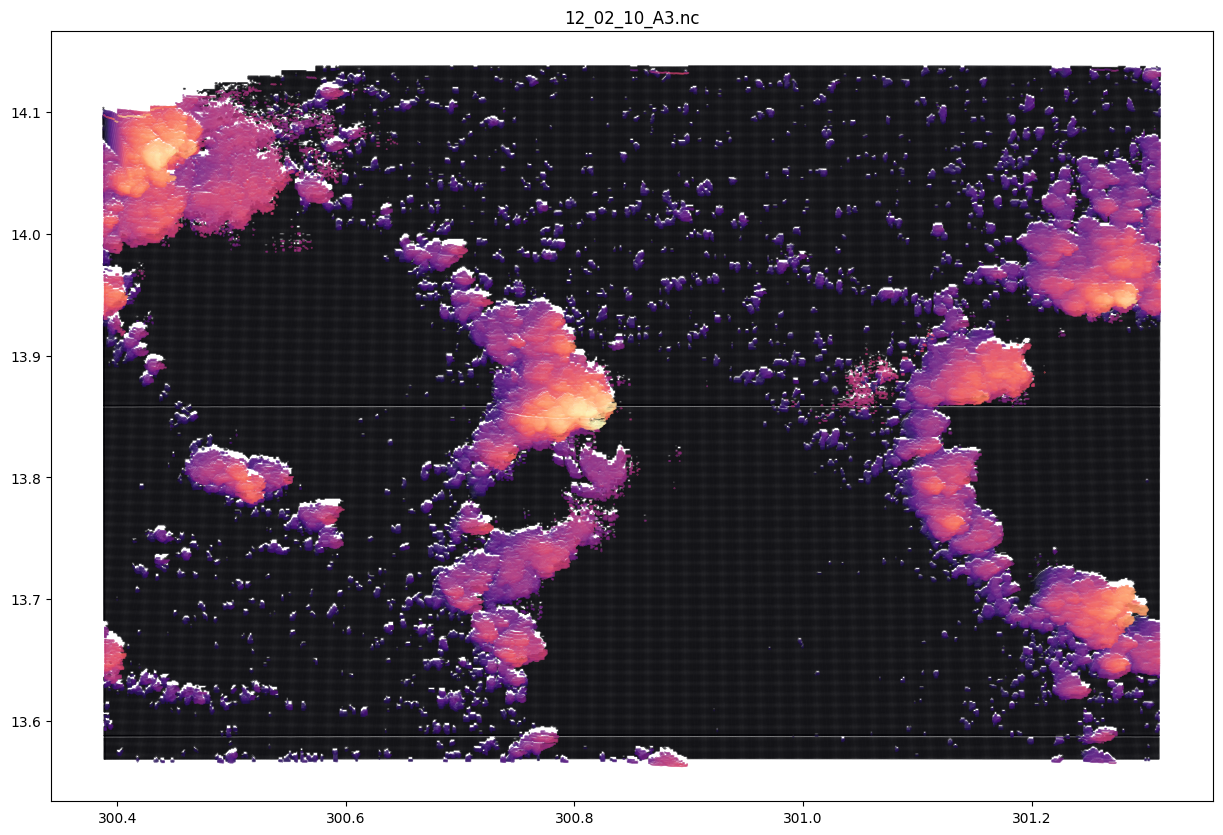

In [4]:
# let us look at one of our netCDF files, as an example. Let's take the A3 one.
filenumber = int(input('Give a digit between 0 and 9 to load a file.'))
filenames =  findaAllFiles(folder='/InitialData',extn ="/*.nc")
filename = filenames[filenumber]
print(filename)
# sample_ds = xr.open_dataset("12_02_10_A3.nc", engine="netcdf4")
sample_ds = xr.load_dataset(filename, engine="netcdf4")
# NB: - open_dataset opens lazily and turns the .nc file to read-only until the corresp. ds has been .closed().
#     - load_dataset loads all the .nc contents into memory closes the .nc file immediately after.

# info for that xr.Dataset:
display(sample_ds)

# extrac data from xarray to numpy array
input_tensor = extract_tensor(sample_ds) # (5,630,1000) tensor: from bottom to top lat, lons, heights, theta, phi
# projection transform
output_tensor = imageTransform(input_tensor)
scatterPlot(output_tensor,input_tensor,filename)
# update the xarray:
update_xarray(sample_ds,output_tensor,filename,folder="/Data")

available files:  ['/home/yz3259/Documents/Python_Jupyter_projects/SWI2023/swi-challenge-2023-netcdf-tutorial-master/Data/new_12_02_10_A3.nc', '/home/yz3259/Documents/Python_Jupyter_projects/SWI2023/swi-challenge-2023-netcdf-tutorial-master/Data/new_12_04_10_A1.nc', '/home/yz3259/Documents/Python_Jupyter_projects/SWI2023/swi-challenge-2023-netcdf-tutorial-master/Data/new_12_01_10_A4.nc', '/home/yz3259/Documents/Python_Jupyter_projects/SWI2023/swi-challenge-2023-netcdf-tutorial-master/Data/new_12_04_10_B3.nc', '/home/yz3259/Documents/Python_Jupyter_projects/SWI2023/swi-challenge-2023-netcdf-tutorial-master/Data/new_12_05_10_B4.nc', '/home/yz3259/Documents/Python_Jupyter_projects/SWI2023/swi-challenge-2023-netcdf-tutorial-master/Data/new_12_03_10_B2.nc', '/home/yz3259/Documents/Python_Jupyter_projects/SWI2023/swi-challenge-2023-netcdf-tutorial-master/Data/new_12_02_10_B1.nc', '/home/yz3259/Documents/Python_Jupyter_projects/SWI2023/swi-challenge-2023-netcdf-tutorial-master/Data/new_12_00_

Give a digit between 0 and 9 to load a file. 0


<xarray.Dataset>
Dimensions:            (iy: 630, ix: 1000)
Coordinates:
  * ix                 (ix) int64 999 998 997 996 995 994 993 ... 6 5 4 3 2 1 0
  * iy                 (iy) int64 0 1 2 3 4 5 6 ... 623 624 625 626 627 628 629
Data variables:
    cloud_edge_height  (iy, ix) float32 0.0675 0.0675 0.0675 ... nan nan nan
    latitude           (iy, ix) float64 13.57 13.57 13.57 ... 14.14 14.14 14.14
    longitude          (iy, ix) float64 301.3 301.3 301.3 ... 300.4 300.4 300.4
    theta_view         (iy, ix) float32 140.9 140.9 140.9 140.9 ... nan nan nan
    phi_view           (iy, ix) float32 92.21 92.21 92.19 92.19 ... nan nan nan
    y_DALES            (iy) float32 0.0 0.1 0.2 0.3 0.4 ... 62.6 62.7 62.8 62.9
    x_DALES            (ix) float32 99.95 99.85 99.75 99.65 ... 0.25 0.15 0.05
    true_latitude      (iy, ix) float64 13.57 13.57 13.57 13.57 ... nan nan nan
    true_longitude     (iy, ix) float64 301.3 301.3 301.3 301.3 ... nan nan nan
Attributes:
    scene:     DALES_highres PAN
    timeslot:  12_02_10
    view:      A3

this is stored data
['', 'home', 'yz3259', 'Documents', 'Python_Jupyter_projects', 'SWI2023', 'swi-challenge-2023-netcdf-tutorial-master', 'Data', 'new_12_02_10_A3.nc']


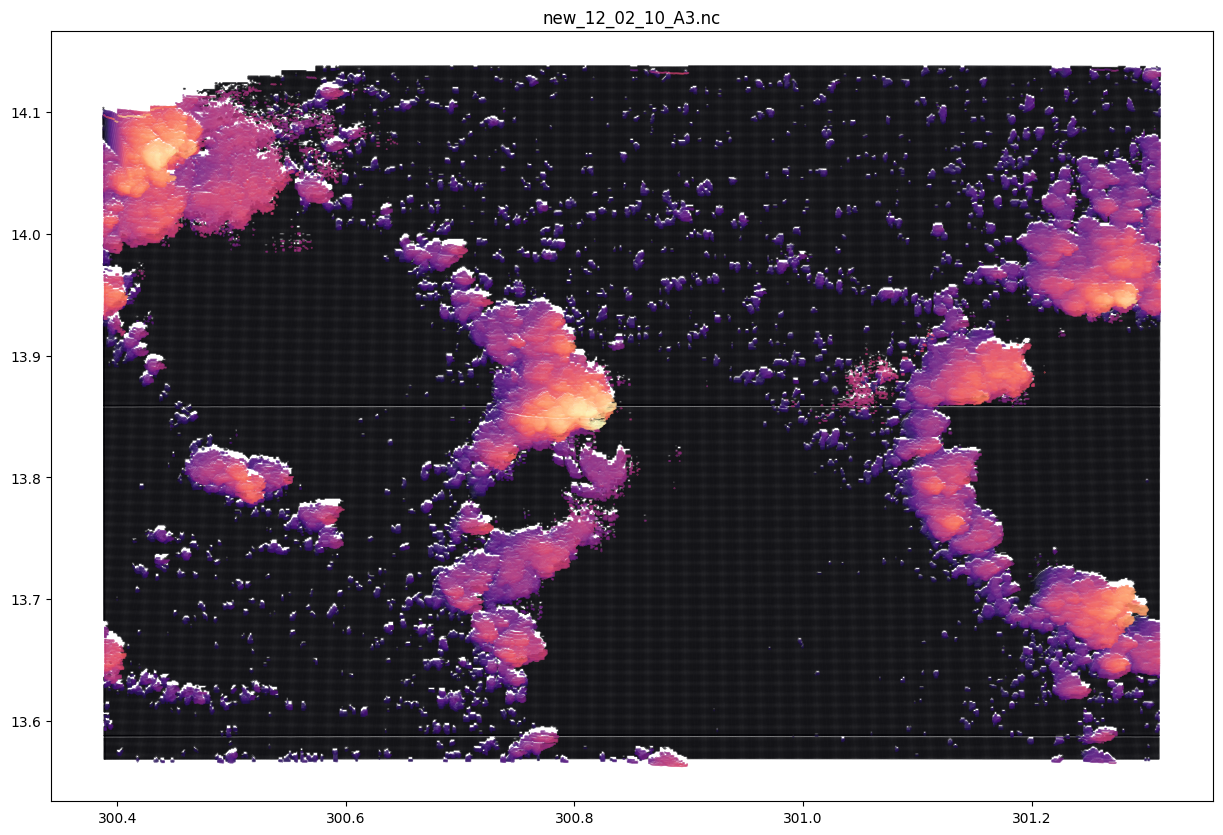

In [5]:
filenames =  findaAllFiles(folder='/Data',extn ="/*.nc")
print('available files: ',filenames)
filenumber = int(input('Give a digit between 0 and 9 to load a file.'))

filename = filenames[filenumber]
sample_ds = xr.load_dataset(filename, engine="netcdf4")
# NB: - open_dataset opens lazily and turns the .nc file to read-only until the corresp. ds has been .closed().
#     - load_dataset loads all the .nc contents into memory closes the .nc file immediately after.

# info for that xr.Dataset:
display(sample_ds)
true_lat = sample_ds.true_latitude.values
true_lon = sample_ds.true_longitude.values
data = np.stack([true_lat,true_lon],axis=0)
data.shape

print('this is stored data')
scatterPlot(data,input_tensor,filename)

In [6]:
# # this loads all data and update them to /Data folder
# for i in range(10):

#     filenames =  findaAllFiles(folder='/InitialData',extn ="/*.nc")
#     filename = filenames[i]
#     print(filename)
#     # sample_ds = xr.open_dataset("12_02_10_A3.nc", engine="netcdf4")
#     sample_ds = xr.load_dataset(filename, engine="netcdf4")
#     # NB: - open_dataset opens lazily and turns the .nc file to read-only until the corresp. ds has been .closed().
#     #     - load_dataset loads all the .nc contents into memory closes the .nc file immediately after.

#     # info for that xr.Dataset:
#     display(sample_ds)

#     # extrac data from xarray to numpy array
#     input_tensor = extract_tensor(sample_ds) # (5,630,1000) tensor: from bottom to top lat, lons, heights, theta, phi
#     # projection transform
#     output_tensor = imageTransform(input_tensor)
#     scatterPlot(output_tensor,input_tensor,filename)
#     # update the xarray:
#     update_xarray(sample_ds,output_tensor,filename,folder="/Data")

In [7]:
# for filenumber in range(10):
    
#     filenames =  findaAllFiles(folder='/Data',extn ="/*.nc")
#     filename = filenames[filenumber]
#     sample_ds = xr.load_dataset(filename, engine="netcdf4")
#     # NB: - open_dataset opens lazily and turns the .nc file to read-only until the corresp. ds has been .closed().
#     #     - load_dataset loads all the .nc contents into memory closes the .nc file immediately after.

#     # info for that xr.Dataset:
#     display(sample_ds)
#     true_lat = sample_ds.true_latitude.values
#     true_lon = sample_ds.true_longitude.values
#     data = np.stack([true_lat,true_lon],axis=0)
#     data.shape
    
#     print('this is stored data')
#     scatterPlot(data,input_tensor,filename)

In [8]:
# Toy data
# theta is 180 deg, phi is 0 deg
# tan part does not work
input_tensor_toy = extract_tensor(sample_ds) # (5,630,1000) tensor: from bottom to top lat, lons, heights, theta, phi

input_tensor_toy[3,:,:]=180.0
input_tensor_toy[4,:,:]=0.0

output_tensor_toy = imageTransform(input_tensor_toy)
scatterPlot(output_tensor_toy,input_tensor_toy)

(630, 1000)
(630, 1000)
(630, 1000)
(630, 1000)
(630, 1000)
shape of input tensor:  (5, 630, 1000)
(2, 630, 1000)


TypeError: scatterPlot() missing 1 required positional argument: 'filename'

In [ ]:
# histogram of the heights data
print(input_tensor[2,:,:].max())
print(input_tensor[2,:,:].min())

# this shows the range of heights

plt.figure(figsize=(12,8))
plt.hist(input_tensor[2,:,:].flatten(),bins = 35)
plt.show()
plt.close()